In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd drive/MyDrive/SER_EmoDB/

In [3]:
import os

import numpy as np
import pandas as pd

import librosa

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Data preprocessing
Our data represented in over 500 recordings of 10 actors, each describes differnt emotions. To prepare data for training, we will true to extract different features and analyse how useful they might be for classification quality.

In [4]:
emotions = {'T':'Sad', 'W':'Angry', 'E':'Disgust', 'A':'Fear', 'F':'Happy', 'N': 'Neutral', 'L':'Boredom'}
audio_path = '/content/drive/MyDrive/SER_EmoDB/archive/wav'
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [5]:
def get_features(data, sample_rate):
  result = np.array([])
  chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate).T
  mfcc = librosa.feature.mfcc(y=data, sr=sample_rate).T
  mel_spec = librosa.feature.melspectrogram(y=data, sr=sample_rate).T
  spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sample_rate).T

  chroma_mean = np.mean(chroma, axis=0)
  mfcc_mean = np.mean(mfcc, axis=0)
  mel_spec_mean = np.mean(mel_spec, axis=0)
  spectral_contrast_mean = np.mean(spectral_contrast, axis=0)

  features = np.hstack((chroma_mean, mfcc_mean, mel_spec_mean, spectral_contrast_mean))

  return features

In [6]:
def augumentation(data):
  strech = librosa.effects.time_stretch(data, rate=0.8)

  noise_factor = 0.3
  noise_amp = noise_factor*np.random.uniform()*np.amax(data)
  noise = data + noise_amp*np.random.normal(size=data.shape[0])
  return strech, noise

In [7]:
def data_with_aug(path):
  data, sample_rate = librosa.load(path)

  pure = get_features(data, sample_rate)
  result = np.array(pure)

  strech, noise = augumentation(data)
  strech_result = get_features(strech, sample_rate)
  noise_result = get_features(noise, sample_rate)

  augm_feature = np.vstack((result,strech_result,noise_result))
  return augm_feature

In [8]:
audio_path = '/content/drive/MyDrive/SER_EmoDB/archive/wav'

X = []
Y = []

for audio_file in os.listdir(audio_path):
  emotion = audio_file[5]
  full_audio_path = os.path.join(audio_path, audio_file)
  features = data_with_aug(full_audio_path)

  for feature in features:
    X.append(feature)
    Y.append(emotion)

In [9]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,labels
0,0.412178,0.452062,0.428127,0.469573,0.509836,0.528947,0.567077,0.576094,0.551222,0.566170,...,3.154457e-12,2.974402e-12,16.675322,11.924536,14.469987,14.105017,16.366236,17.355019,63.011414,T
1,0.341058,0.406384,0.419718,0.394319,0.412316,0.477693,0.490799,0.534748,0.477283,0.486868,...,5.653016e-10,5.609175e-10,17.823891,13.611305,16.346481,16.144105,17.497670,19.083296,63.715198,T
2,0.610977,0.636623,0.634685,0.704500,0.707506,0.616759,0.595547,0.622845,0.700467,0.714492,...,7.167068e-01,7.335483e-01,14.328337,11.755657,12.796586,12.738645,13.372033,13.496212,13.913411,T
3,0.463265,0.448260,0.474463,0.566774,0.517713,0.521108,0.495570,0.453649,0.430374,0.412603,...,3.311930e-11,3.258661e-11,17.749477,12.800549,16.926222,14.566510,17.356381,19.159200,57.707527,N
4,0.396143,0.350007,0.470785,0.454095,0.464590,0.493523,0.394313,0.349247,0.339749,0.277634,...,3.770229e-11,3.725242e-11,18.944901,14.562624,18.098463,16.483515,18.588089,20.884659,58.548714,N


Data preprocessing

In [10]:
Y = Features.labels
X = Features.drop('labels', axis=1)
encoder = sklearn.preprocessing.OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1284, 167), (1284, 7), (161, 167), (161, 7))

Reshape for the model

In [12]:
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_val.shape

((1284, 167, 1), (1284, 7), (161, 167, 1), (161, 7), (160, 7))

In [13]:
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample = {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }
        return sample

In [14]:
train_dataset = EmotionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EmotionDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

val_dataset = EmotionDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Model architecture

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.model = torch.nn.Sequential(
          nn.Conv1d(in_channels=167, out_channels=256, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

          nn.Conv1d(in_channels=256, out_channels=256, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

          nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

          nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

          nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

          nn.Flatten(),
          nn.Linear(64, 32),
          nn.Dropout(p=0.3),
          nn.Linear(32, num_classes)
          )

    def forward(self, x):
        x = self.model(x)

        return x


net = CNN(7)

Hyperparams

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [17]:
def checkpoint(model,optimizer, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, filename)

def resume(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

Epoch [1/30], Loss: 1.8207, Val_Loss:1.6344, Acc: 22.82%
Epoch [2/30], Loss: 1.4902, Val_Loss:1.4168, Acc: 36.45%
Epoch [3/30], Loss: 1.3469, Val_Loss:1.2926, Acc: 41.98%
Epoch [4/30], Loss: 1.2336, Val_Loss:1.1523, Acc: 50.00%
Epoch [5/30], Loss: 1.1413, Val_Loss:1.1412, Acc: 52.73%
Epoch [6/30], Loss: 1.0687, Val_Loss:1.0964, Acc: 54.98%
Epoch [7/30], Loss: 0.9755, Val_Loss:0.9170, Acc: 55.84%
Epoch [8/30], Loss: 0.8717, Val_Loss:0.9235, Acc: 60.51%
Epoch [9/30], Loss: 0.8755, Val_Loss:1.0816, Acc: 62.46%
Epoch [10/30], Loss: 0.8920, Val_Loss:0.8530, Acc: 60.75%
Epoch [11/30], Loss: 0.8269, Val_Loss:1.0081, Acc: 63.16%
Epoch [12/30], Loss: 0.7696, Val_Loss:0.8146, Acc: 66.12%
Epoch [13/30], Loss: 0.6941, Val_Loss:0.7527, Acc: 67.13%
Epoch [14/30], Loss: 0.7262, Val_Loss:0.8411, Acc: 68.93%
Epoch [15/30], Loss: 0.6096, Val_Loss:0.7763, Acc: 72.51%
Epoch [16/30], Loss: 0.5837, Val_Loss:0.7789, Acc: 76.09%
Epoch [17/30], Loss: 0.5285, Val_Loss:0.7777, Acc: 76.48%
Epoch [18/30], Loss: 0.

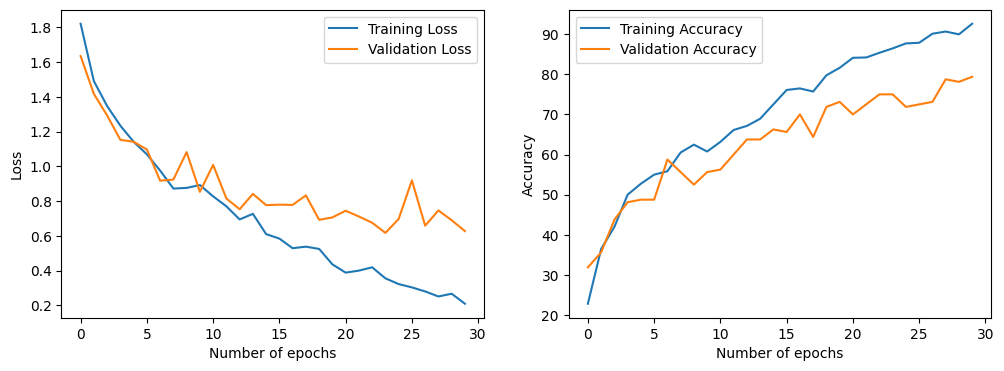

In [18]:
num_epochs = 30
start_epoch = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(net, f"checkpoints/epoch-{resume_epoch}.pth")


best_val_accuracy = 0
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_data in train_loader:
        batch_inputs = batch_data['features']
        batch_targets = batch_data['label']

        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        batch_outputs = net(batch_inputs)

        # Compute loss
        loss = criterion(batch_outputs, batch_targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(batch_outputs.data, 1)
        total += batch_targets.size(0)
        correct += (predicted == torch.argmax(batch_targets,1)).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    valid_loss = 0.0
    val_correct = 0
    val_total = 0

    net.eval()
    with torch.no_grad():
        for batch_data in val_loader:
            batch_inputs = batch_data['features']
            batch_targets = batch_data['label']

            outputs = net(batch_inputs)
            val_loss = criterion(outputs, batch_targets)
            valid_loss += val_loss.item()

            _, val_predicted = torch.max(outputs.data, 1)
            val_total += batch_targets.size(0)
            val_correct += (val_predicted == torch.argmax(batch_targets,1)).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_losses.append(valid_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save the current model as the best checkpoint
        checkpoint(net, optimizer, 'checkpoints/best_model.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}, Val_Loss:{valid_loss / len(val_loader):.4f}, Acc: {train_accuracy:.2f}%")

    checkpoint(net,optimizer, f"checkpoints/epoch-{epoch}.pth")

# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
checkpoint_path = f'checkpoints/best_model.pth'  # Change this to the path of your best model checkpoint
resume(net, checkpoint_path)
net.eval()

# Iterate through the test dataset and make predictions
test_correct = 0
test_total = 0

predictions = []
true_values = []

with torch.no_grad():
    for batch_data in test_dataloader:
        batch_inputs = batch_data['features']
        batch_targets = batch_data['label']

        outputs = net(batch_inputs)
        _, predicted = torch.max(outputs.data, 1)


        predictions.extend(encoder.inverse_transform(outputs))
        true_values.extend(encoder.inverse_transform(batch_targets))

        test_total += batch_targets.size(0)
        test_correct += (predicted == torch.argmax(batch_targets,dim=1)).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 78.26%


In [20]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = true_values
df['Actual Labels'] = predictions

df.head(10)

,Predicted Labels,Actual Labels
0,[W],[W]
1,[E],[E]
2,[F],[F]
3,[L],[L]
4,[L],[N]
5,[N],[N]
6,[W],[W]
7,[L],[N]
8,[N],[E]
9,[A],[A]


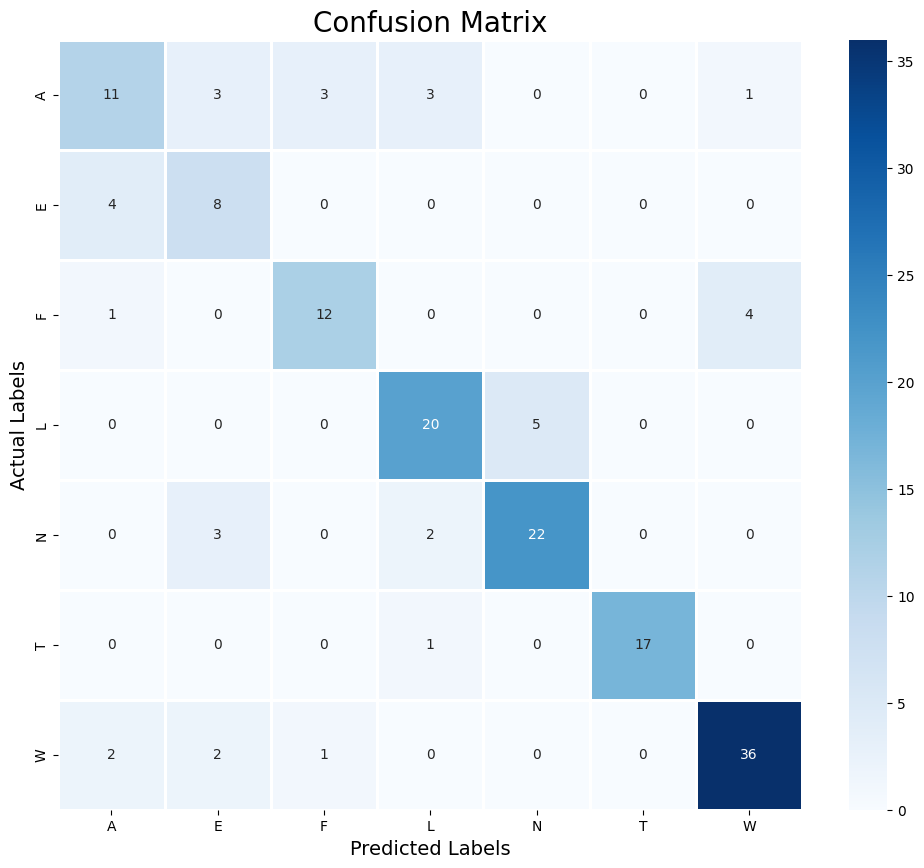

In [21]:
cm = confusion_matrix(true_values, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

Test on my voice data

In [22]:
my_voice_path = '/content/drive/MyDrive/SER_EmoDB/alina_voice'

preprocessing data

In [23]:
my_X = []
my_Y = []

for audio_file in os.listdir(my_voice_path):
  emotion = audio_file.split('.')[0]
  print(emotion)
  full_audio_path = os.path.join(my_voice_path, audio_file)
  features = data_with_aug(full_audio_path)

  for feature in features:
    my_X.append(feature)
    my_Y.append(emotion)

W
A
T
E
F
N
L


In [24]:
Features = pd.DataFrame(my_X)
Features['labels'] = my_Y

Y = Features.labels
X = Features.drop('labels', axis=1)
encoder = sklearn.preprocessing.OneHotEncoder()

#reshape and prepare data for model
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
X= scaler.transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape, Y.shape)
myvoice_dataset = EmotionDataset(X, Y)
myvoice_loader =  DataLoader(myvoice_dataset,shuffle=False)

checkpoint_path = f'checkpoints/best_model.pth'  # Change this to the path of your best model checkpoint
resume(net, checkpoint_path)


correct = 0
total = 0

predictions = []
true_values = []

with torch.no_grad():
    for batch_data in myvoice_loader:
        batch_inputs = batch_data['features']
        batch_targets = batch_data['label']

        outputs = net(batch_inputs)
        _, predicted = torch.max(outputs.data, 1)

        predictions.append(encoder.inverse_transform(outputs))
        true_values.append(encoder.inverse_transform(batch_targets))

        total += batch_targets.size(0)
        correct += (predicted == torch.argmax(batch_targets,dim=1)).sum().item()

accuracy = 100 * correct / total
print(f"My Voice Accuracy: {accuracy:.2f}%")


(21, 167, 1) (21, 7)
My Voice Accuracy: 14.29%


In [26]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = true_values
df['Actual Labels'] = predictions

df

,Predicted Labels,Actual Labels
0,[[W]],[[W]]
1,[[W]],[[W]]
2,[[W]],[[A]]
3,[[A]],[[W]]
4,[[A]],[[W]]
5,[[A]],[[A]]
6,[[T]],[[W]]
7,[[T]],[[W]]
8,[[T]],[[A]]
9,[[E]],[[W]]
